In [1090]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [1091]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
# σy = 1.2*np.mean(θ_list)
σy = 0*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_jump=2
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
# γ3_list[0] = 0
# γ3_list[0] = np.mean(np.array([0, 0.0197*2, 0.3853*2]))
# γ3_list[0] = 1/3
γ3_list[0] = 0.0197*2
# γ3_list[0] = 0.05
# γ3_list[0] = 1/3

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [1092]:
y_step = 0.04
y_grid = np.arange(0., 4 + y_step, y_step)

k_step = 0.1
k_grid = np.arange(0., 9.0 + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [1093]:
y_mat.shape
# np.mean(np.array([0, 0.0197*2, 0.3853*2]))

(101, 91)

In [1094]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)
    v0 =  -  η*y_mat**2 + k_mat**2
    ems_new = η*y_mat**2 + k_mat**2
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    vd = - 1/δ
    while lhs_error > tol:
        if episode ==0:
            i = 0
            ems = ems_new
            mc_new = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems/np.exp(k_mat))**θ) )
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,dy)
        v0_dyy = derivatives_2d(v0,0,2,dy)
        v0_dk = derivatives_2d(v0,1,1,dk)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
        v0_dkk = derivatives_2d(v0,1,2,dk)
        # updating controls
        mc = mc_new
        i_new = 1 - mc/v0_dk
        # update emission
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
        b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new[ems_new < 1e-15] = 1e-15
        mc_new = 1/(α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))**θ) )
#         ems_new[ems_new <= 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5

#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
        print(np.min(ems_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems_new
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + 
$$

In [1095]:
# HJB for ϕ_m
# θ = 2
θ = 3
y_bar = 2
ξa = 0.01
# ξa = 10000
ξb = 3
# ξb = 10000
λ_bar = 0.134
# λ_bar = 0.102
# λ_bar = 0.0925
# ϑ_bar = 0.078
# ϑ_bar = 0.054
# ϑ_bar = 0.048

ϑ_bar = 0.052
# ϑ_bar = 0.036
# ϑ_bar = 0.032

γ3 = γ3_list[0]

α=0.115

ϵ=2.5
# ϵ=0.5

# κ=7.5


max_iter=2000
tol=1e-7

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)


# initial guess
v0 =  (1/δ)*k_mat  -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)


drift = (i - 0.5*κ*(i**2) + μk)

# stop


ems = 0*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ
# vd = - η/δ

while lhs_error > tol:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
    v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission

    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
#         ems_new = (ems_new)*(ems_new>0)
    elif θ == 3:
        b = v0_dyy*σy**2 + vd*ddΛ*σy**2 - 2*mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        c = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        a = mc*θ*ϑ_bar/(α**2*λ_bar**3*np.exp(3*k_mat))    
        ems_new =  (-b-np.sqrt(b**2 - 4*a*c))/(2*a)
#         ems_new = (ems_new)*(ems_new>0)
    
#     ems_new[ems_new < 1e-15] = 1e-15
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[c# mc[mc < 1e-15] = 1e-1510onsumption <= 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: -12.129554741315383
min mc 48.040957957631406
Episode 0: PDE Error: 1.947899302746; False Transient Error: 1.901445393365; Iterations: 28; CG Error: 0.000000000095
min ems: -18.336380552046652
min mc 45.2457461173608
Episode 1: PDE Error: 1.894340733584; False Transient Error: 1.849489840292; Iterations: 36; CG Error: 0.000000000070
min ems: -23.892848125560956
min mc 43.39133925461441
Episode 2: PDE Error: 1.845170125187; False Transient Error: 1.801730051440; Iterations: 43; CG Error: 0.000000000062
min ems: -28.798725973178303
min mc 42.11150877604284
Episode 3: PDE Error: 1.798712480749; False Transient Error: 1.756529287781; Iterations: 48; CG Error: 0.000000000083
min ems: -33.04751930644667
min mc 41.209432213956
Episode 4: PDE Error: 1.754305409659; False Transient Error: 1.713294525275; Iterations: 52; CG Error: 0.000000000097
min ems: -36.65120709125008
min mc 40.56804731533993
Episode 5: PDE Error: 1.711451094280; False Transient Error: 1.671548908329; Iterations: 5

Episode 48: PDE Error: 0.566741431448; False Transient Error: 0.552067973847; Iterations: 84; CG Error: 0.000000000089
min ems: -6.930289874746706
min mc 38.872115750330714
Episode 49: PDE Error: 0.552055639103; False Transient Error: 0.538023318049; Iterations: 86; CG Error: 0.000000000077
min ems: -6.44218749969081
min mc 38.86631077588081
Episode 50: PDE Error: 0.537771527770; False Transient Error: 0.524336689744; Iterations: 87; CG Error: 0.000000000087
min ems: -6.000028409608746
min mc 38.861565310413006
Episode 51: PDE Error: 0.523873996047; False Transient Error: 0.511012029371; Iterations: 88; CG Error: 0.000000000096
min ems: -5.600527434773206
min mc 38.85787173877316
Episode 52: PDE Error: 0.510347921031; False Transient Error: 0.498077797724; Iterations: 90; CG Error: 0.000000000082
min ems: -5.240418572419252
min mc 38.855122579622446
Episode 53: PDE Error: 0.497216925581; False Transient Error: 0.485461425572; Iterations: 91; CG Error: 0.000000000089
min ems: -4.9165528

Episode 96: PDE Error: 0.196190615398; False Transient Error: 0.189585157081; Iterations: 107; CG Error: 0.000000000089
min ems: -3.575411582721098
min mc 38.95652781846308
Episode 97: PDE Error: 0.192155965569; False Transient Error: 0.185585784659; Iterations: 107; CG Error: 0.000000000087
min ems: -3.593128813540633
min mc 38.950744987448886
Episode 98: PDE Error: 0.188202518482; False Transient Error: 0.181686229009; Iterations: 107; CG Error: 0.000000000085
min ems: -3.607541602137813
min mc 38.944671232288606
Episode 99: PDE Error: 0.184328612702; False Transient Error: 0.177846377466; Iterations: 107; CG Error: 0.000000000083
min ems: -3.618663417571124
min mc 38.93828367988799
Episode 100: PDE Error: 0.180532641194; False Transient Error: 0.174102265262; Iterations: 107; CG Error: 0.000000000081
min ems: -3.626577893197067
min mc 38.931842160037306
Episode 101: PDE Error: 0.176813047144; False Transient Error: 0.170418637405; Iterations: 106; CG Error: 0.000000000099
min ems: -

Episode 144: PDE Error: 0.072040796500; False Transient Error: 0.065719155440; Iterations: 99; CG Error: 0.000000000098
min ems: -4.092887744972664
min mc 38.695198302807775
Episode 145: PDE Error: 0.070568217834; False Transient Error: 0.064294234064; Iterations: 99; CG Error: 0.000000000095
min ems: -4.08680542858548
min mc 38.69165221206998
Episode 146: PDE Error: 0.069127572199; False Transient Error: 0.062895279308; Iterations: 99; CG Error: 0.000000000093
min ems: -4.083277353448215
min mc 38.68822233857654
Episode 147: PDE Error: 0.067718211677; False Transient Error: 0.061522728598; Iterations: 99; CG Error: 0.000000000091
min ems: -4.081868245617848
min mc 38.68490542850263
Episode 148: PDE Error: 0.066339498781; False Transient Error: 0.060176568707; Iterations: 99; CG Error: 0.000000000089
min ems: -4.08220715679161
min mc 38.681698257693206
Episode 149: PDE Error: 0.064990806643; False Transient Error: 0.058856269561; Iterations: 99; CG Error: 0.000000000087
min ems: -4.084

<ipython-input-1095-bc61b6f0ca0d>:94: RuntimeWarning: invalid value encountered in sqrt
  ems_new =  (-b-np.sqrt(b**2 - 4*a*c))/(2*a)


Episode 191: PDE Error: nan; False Transient Error: nan; Iterations: 18382; CG Error: nan


In [1069]:
drift

0.01999812061010396

No handles with labels found to put in legend.


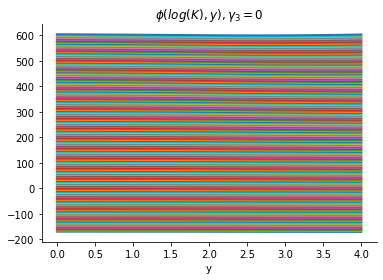

In [1071]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid, v0)
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

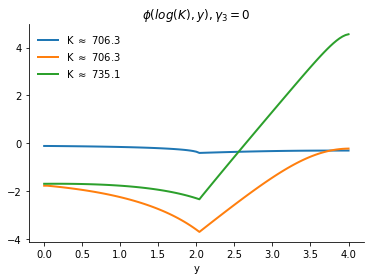

In [1072]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid, v0_dy[:, 0], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0_dy[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0_dy[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

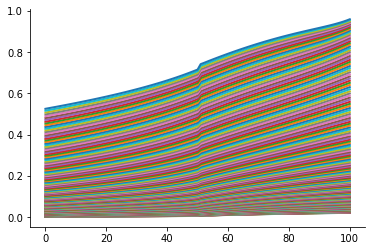

In [1073]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

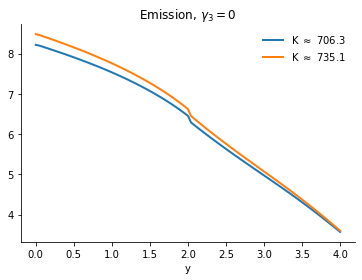

In [1074]:
# plt.plot(y_grid, ems[:, -1])
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('emission_01.png', dpi=300)
# plt.ylim(0,12)

In [1075]:
y_grid[-39], y_mat.shape

(2.48, (101, 201))

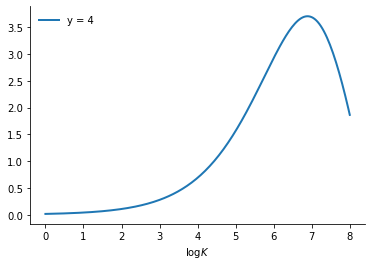

In [1076]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
plt.savefig('e_logk.png')

In [1077]:
np.exp(7), y_grid[40]

(1096.6331584284585, 1.6)

Text(0.5, 1.0, 'Emission')

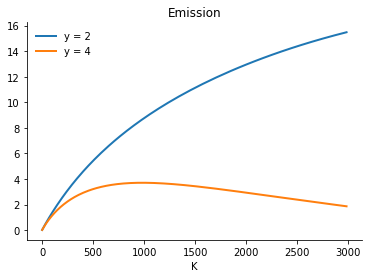

In [1078]:
plt.plot(np.exp(k_grid), ems[40], label = "y = 2")
plt.plot(np.exp(k_grid), ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('K')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 1.0, 'Emission')

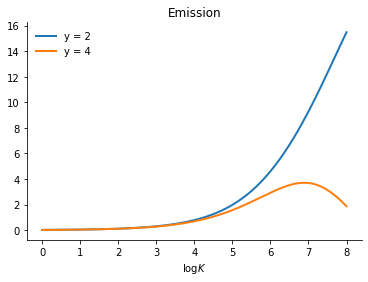

In [1079]:
plt.plot(k_grid, ems[40], label = "y = 2")
plt.plot(k_grid, ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

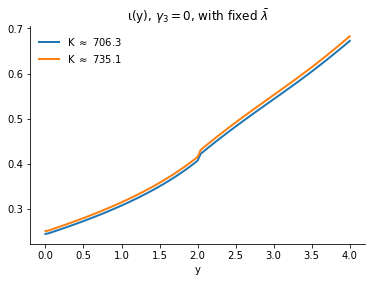

In [1080]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

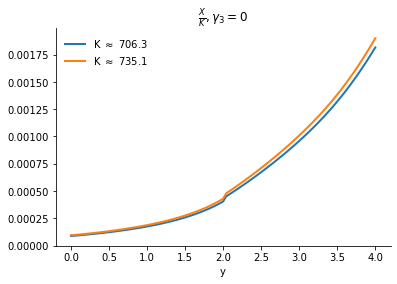

In [1081]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

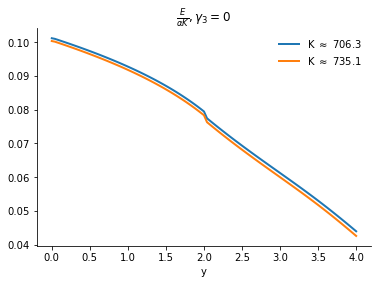

In [1082]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

In [1083]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [1084]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [1085]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

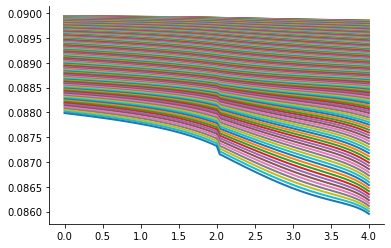

In [1086]:
plt.plot(y_grid, i)
plt.show()

In [1087]:
Time = 100
ppy = 12
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

gridpoints = (y_grid, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = γ1*Y_0 + γ2*Y_0**2 + γ3*((Y_0 - y_bar)**2)*(Y_0 >y_bar)
          
# stop
hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])

    else:
        # other periods
        hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
        hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
        hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
        e_hist[tm] = e_func(hist[tm,:])
        i_hist[tm] = i_func(hist[tm,:])

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

ValueError: One of the requested xi is out of bounds in dimension 1

0.005518425000000001

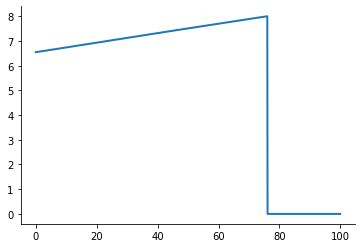

In [1088]:
plt.plot(np.arange(0, Time, dt), hist[:,1])
np.log(K_0)
γ1*Y_0 + γ2*Y_0**2 + γ3*((Y_0 - y_bar)**2)*(Y_0 >y_bar)

Text(0.5, 0, 'Years')

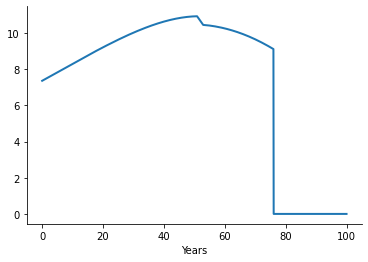

In [1089]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
# plt.savefig('Et.png')

In [993]:
e_hist[12*50]

11.303813669785931

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

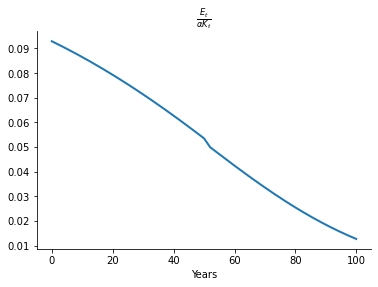

In [987]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

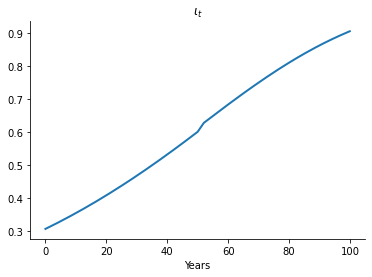

In [988]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t.png')

In [989]:
hist[480],e_hist[480]

(array([1.79267637, 7.32357344, 0.01008522]), 10.922290599897297)

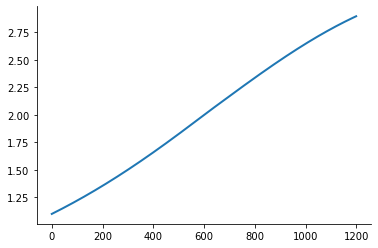

In [990]:
plt.plot(hist[:,0])

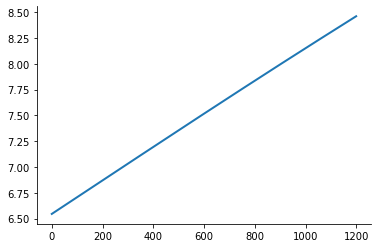

In [964]:
plt.plot(simul['states'][:, 1])

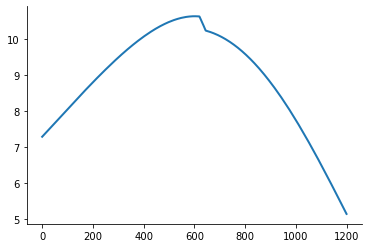

In [965]:
plt.plot(simul['e'])